In [1]:
from adtk.visualization import plot
from adtk.data import validate_series
from adtk.detector import InterQuartileRangeAD

In [2]:
import os,re, glob, csv, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import netCDF4 as nc
from collections import Counter

In [3]:
matches_list = [ 'soil_moist_20min_Kendall_AZ_*','soil_moist_20min_Vaira_CA_*','soil_moist_20min_BLMLand1STonzi_CA_*','soil_moist_20min_LuckyHills_AZ_*',
                'soil_moist_20min_MatthaeiGardens_*','soil_moist_20min_NewHoganLakeN_CA_*',
                'soil_moist_20min_TerradOro_CA_*',
                'soil_moist_20min_TonziRanch_CA_*','soil_moist_20min_BLMLand2STonzi_CA_*','soil_moist_20min_BLMLand3NTonzi_CA_*']
data_path = "/media/sonakshireddy/9C33-6BBD/zipped/Users/M Sonakshi/Documents/soil/soil/SoilSCAPE_1339/SoilSCAPE_1339/data/"

In [4]:
def isNaN(num):
    return num != num

### Function to find the longest sequence without nulls and the longest consequent gaps

In [5]:
def find_longest_seq_count(s1):
    max_val = 0
    longest_gap = 0
    long_seq = 0
    max_long_seq = 0
    num_gaps=0
    no_nulls=True
    for val in s1:
        if isNaN(val):
            if max_val==0:
                num_gaps+=1
            no_nulls=False
            max_val+=1
            if max_long_seq<long_seq:
                max_long_seq = long_seq
            long_seq = 0
        else:
            long_seq+=1
            if longest_gap<max_val:
                longest_gap = max_val
            max_val = 0
    if max_long_seq<long_seq:
        max_long_seq = long_seq
    if longest_gap<max_val:
        longest_gap = max_val
    if no_nulls:
        max_long_seq = s1.shape[0]
    return max_long_seq, longest_gap,num_gaps

### Finding the longest seq and gaps for every soilscape site at different depths

In [6]:
def get_data_depth_wise(matches_list):
    list_dict = []
    for match_str in matches_list:
        for f in glob.glob(os.path.join(data_path+match_str)):
            d1 = {}
            site_str = f.split("\\")[1][17:-7]
            d1['site'] = site_str
            in_nc = nc.Dataset(os.path.join(data_path, f))
            daily_df = avg_daily_sm_data(in_nc)
            daily_df = daily_df.replace(0,np.nan)
            node_id = ""
            m = re.match(".*n(\\d+).*", f)
            if m:
                node_id = m.group(1)
                d1['node_id'] = node_id
            daily_df['date'] = pd.to_datetime(daily_df['date'], format='%Y%m%d').apply(lambda x: x.date())
            daily_df.index = daily_df['date']
            d1['total_rows'] = daily_df.shape[0]
            daily_df = daily_df.drop(columns=['date'])
            d1['start'] = list(daily_df.index)[0]
            d1['end'] = list(daily_df.index)[-1]
            gap_dict = {}
            seq_dict={}
            num_gaps = {}
            for col in daily_df.columns:
                seq_dict[col],gap_dict[col],num_gaps[col] = find_longest_seq_count(daily_df[col])
            v = daily_df.isnull().sum()
            depth_null = list(zip(v.index,v))
            for a in depth_null:
                d = d1.copy()
                d['depth'] = a[0]
                d['nulls'] = a[1]
                d['filled_percentage'] = 1 - d['nulls']/float(d['total_rows'])
                d['longest_gap'] = gap_dict[a[0]]
                d['longest_seq'] = seq_dict[a[0]]
                d['num_gaps']  = num_gaps[a[0]]
                list_dict.append(d)
    with open("C:/Users/M Sonakshi/Documents/soil_imgs/countVis/nodewisedata.csv",'w',newline="") as f:
        keys = list_dict[0].keys()
        writer = csv.DictWriter(f,['site','node_id','depth','start','end','nulls','total_rows','filled_percentage','longest_gap','longest_seq','num_gaps'])
        writer.writeheader()
        writer.writerows(list_dict)
                

### Reading the hourly soilscape data for all sites

In [7]:
filtered = pd.read_csv("/home/sonakshireddy/Documents/soil/soil/pred_exp/merge_all_result_hourly.csv",sep=";")
filtered = filtered.sort_values(by=['date'])
filtered.index = filtered.date
filtered=filtered.replace(0,np.nan)

### Finding the gaps and sequences arrays and their corresponding dates for a particular subset of data (ex: Yearly data)

In [8]:
def get_dates_filter(s1,dates):
    max_val = 0
    longest_gap = 0
    long_seq = 0
    max_long_seq = 0
    no_nulls=True
    gaps = []
    starts = []
    ends = []
    mls_start = []
    mls_end = []
    seqs=[]
    for val,date in zip(s1,dates):
        if isNaN(val):
            no_nulls=False
            if max_val ==0:
                starts.append(date)
            max_val+=1
            if max_long_seq<long_seq:
                max_long_seq = long_seq
            if long_seq > 0:
                seqs.append(long_seq)
                mls_end.append(date)
            long_seq = 0
        else:
            if long_seq ==0:
                mls_start.append(date)
            long_seq+=1
            if longest_gap<max_val:
                longest_gap = max_val
            if max_val > 0:
                gaps.append(max_val)
                ends.append(date)
            max_val = 0
    if max_long_seq<long_seq:
        max_long_seq = long_seq
    if longest_gap<max_val:
        longest_gap = max_val
    if max_val>0:    
        ends.append(dates[-1])
        gaps.append(max_val)
    if no_nulls:
        max_long_seq = s1.shape[0]
    if long_seq > 0:
        mls_end.append(dates[-1])
        seqs.append(long_seq)
    d = dict()
    d['gaps'] = gaps
    d['starts'] = starts
    d['ends'] = ends
    d['mls_start'] = mls_start
    d['mls_end'] = mls_end
    d['seqs'] = seqs
    d['long_seq'] = max_long_seq
    d['longest_gap'] = longest_gap
    return d

In [9]:
d1 =get_dates_filter(filtered['BLMLand1STonzi_CAn=900_d=5'],list(filtered.date))


### Finding the longest sequence in a year with the least number of gaps and max number of values

In [10]:
def get_long_seq_tup(d1):
    for tup in list(zip(d1['seqs'],d1['mls_start'],d1['mls_end'])):
        if d1['long_seq'] == tup[0]:
            return tup

        
def index_for_gaps(d1,seq_start,seq_end):
    start_gap = None
    end_gap = None
    for i,tup in enumerate(list(zip(d1['gaps'],d1['starts'],d1['ends']))):
        if seq_start == tup[2]:
            start_gap = i
        if seq_end == tup[1]:
            end_gap = i
        if start_gap and end_gap:
            return start_gap, end_gap
    return start_gap, end_gap

def get_modified_start_date_for_seq(seq_gaps, start_gap):
    start_seq = None
    for i in reversed(range(start_gap+1)):
        if seq_gaps[i][0] < 45:
            if i>0:
                start_seq = seq_gaps[i-1][2]
            else:
                start_seq = seq_gaps[i][1]
        else:
            return start_seq
    return start_seq


def get_modified_seq_end_date(seq_gaps,end_gap):
    end_seq = None
    for i in range(end_gap,len(seq_gaps)):
        if seq_gaps[i][0] < 45:
            if i < len(seq_gaps)-1:
                end_seq = seq_gaps[i+1][1]
            else:
                end_seq = seq_gaps[i][2]
        else:
            return end_seq
    return end_seq

In [11]:
col ='NewHoganLakeN_CAn=709_d=5'

In [12]:
sample = filtered[col]
res_tup=[]
d1 =get_dates_filter(filtered[col],list(filtered.index))
seq_tuple = list(zip(d1['seqs'],d1['mls_start'],d1['mls_end']))
seq_gaps = list(zip(d1['gaps'],d1['starts'],d1['ends']))
if seq_tuple:
    _,seq_start,seq_end = get_long_seq_tup(d1)
    start_gap, end_gap = index_for_gaps(d1, seq_start,seq_end)
    if start_gap:
        start_seq_modified = get_modified_start_date_for_seq(seq_gaps,start_gap)
        if start_seq_modified:
            seq_start = start_seq_modified
    if end_gap:
        end_seq_modified = get_modified_seq_end_date(seq_gaps,end_gap)
        if end_seq_modified:
            seq_end = end_seq_modified
    res_tup.append((col,seq_start,seq_end))

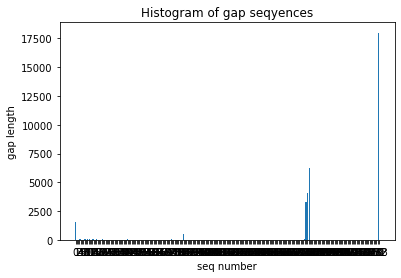

In [13]:
x = [str(i) for i in range(len(d1['gaps']))]
plt.bar(x,d1['gaps'])  # arguments are passed to np.histogram
plt.title("Histogram of gap seqyences")
plt.xlabel('seq number')
plt.ylabel('gap length')
plt.show()

In [14]:
filtered = pd.read_csv("/home/sonakshireddy/Documents/soil/merged_data_tera.csv")
filtered.date = pd.to_datetime(filtered.date)
del filtered['Unnamed: 0']
filtered.index = filtered.date

In [15]:
def check_month_full(s):
    list_months = []
    if s.dropna().shape[0] >= 26*24: 
        return s.index[0].month
    return None

In [16]:
def plot_hist(s1,res_tup,col):
    d1 = get_dates_filter(s1[col], list(s1.index))
    year = s1.index[0].year
    seq_tuple = list(zip(d1['seqs'], d1['mls_start'], d1['mls_end']))
    seq_gaps = list(zip(d1['gaps'], d1['starts'], d1['ends']))
    if seq_tuple:
#         if not d1['gaps'] or (d1['gaps'] and max(d1['gaps'])<=24):
            if s1.dropna().shape[0]>=360*24:
                max_val = 0
                if d1['gaps']:
                    max_val  = max(d1['gaps'])
                print("{},{},{},{}".format(col,year,s1.dropna().shape[0],max_val))
                return year
    return None
#                 value = s1.groupby(pd.Grouper(key='time',freq='m')).apply(lambda a:check_month_full(a))
#                 list_months = list(value.dropna())
#                 list_month_check = [i for i in range(list_months[0],list_months[0]+len(list_months))]
#                     res_tup.append((list_months[0],len(list_months)-1,col + "_"+str(year)))
#         _, seq_start, seq_end = get_long_seq_tup(d1)
#         start_gap, end_gap = index_for_gaps(d1, seq_start, seq_end)
#         if start_gap:
#             start_seq_modified = get_modified_start_date_for_seq(seq_gaps, start_gap)
#             if start_seq_modified:
#                 seq_start = start_seq_modified
#         if end_gap:
#             end_seq_modified = get_modified_seq_end_date(seq_gaps, end_gap)
#             if end_seq_modified:
#                 seq_end = end_seq_modified
#         res_tup.append((col, seq_start, seq_end))
        # x = [str(i) for i in range(len(d1['gaps']))]
        ### plotting gap length vs gap length count
#         if d1['gaps']:
#             plt.figure(figsize=(20, 10))
#             fig = plt.gcf()
#             counter_y = list(zip(*sorted(Counter(d1['gaps']).items())))
#             plt.bar(list(map(str,counter_y[0])),counter_y[1], align='center', width=0.3)
#             plt.title("Histogram of gap sequences of {}".format(col))
#             plt.xlabel('gap length')
#             plt.ylabel('gap length count')
#     #         fig.autofmt_xdate()
#             fig.savefig('/home/sonakshireddy/Documents/hist_gap_length_count/' + col + ".png")
#             plt.close('all')

### Finding the start and end dates for each node at different sites

In [17]:
## retrieving the start and end dates for each node
try:
    merged_df_dict = {}
    res_tup = []
    list_cols = list(filtered.columns)
    list_cols.remove('date')
    for col in list_cols:
        if not re.match('.*Vaira_CA_*',col):
            sample = filtered[col]
            sample = sample.dropna()
            if not sample.empty and sample.shape[0]>10:
                sample.index = pd.to_datetime(sample.index)
                s1 =sample.resample('H').mean()
#                 plot_hist(s1,res_tup,col)
                x = pd.DataFrame(s1)
                x.index = pd.to_datetime(x.index)
                x['time'] = x.index
                years_df = x.groupby(pd.Grouper(key='time',freq='Y')).apply(lambda x:plot_hist(x,res_tup,col))
                if not years_df.empty:
                    years_df = years_df.dropna()
                    for i in range(years_df.shape[0]):
                        key = str(int(years_df.iloc[i]))
                        filtered.index = pd.to_datetime(filtered.index)
#                         
                        if key not in merged_df_dict:
                            merged_df_dict[key] = pd.DataFrame(filtered[filtered.index.year == int(years_df.iloc[i])][col].resample('H').mean())
                        else:
#                             print(pd.DataFrame(filtered[filtered.index.year == int(years_df.iloc[i])][col].resample('H').mean()))
                            merged_df_dict[key] = merged_df_dict[key].merge(pd.DataFrame(filtered[filtered.index.year == int(years_df.iloc[i])][col].resample('H').mean()),
                                                         left_index=True,right_index=True, how='outer')
#     for key in merged_df_dict:
#         merged_df_dict[key].to_csv("/home/sonakshireddy/Documents/yearly_data_tonzi/{}.csv".format(key))
                
#         res_tup_array = list(zip(*res_tup))
#         plt.figure(figsize=(20, 10))
#         fig = plt.gcf()
#         plt.bar(res_tup_array[2], res_tup_array[1],bottom = res_tup_array[0], align='center', width=0.3)
#         plt.title("Bar chart of node: {} having the mentioned months data in year {}".format(col,year))
#         plt.xlabel('')
#         plt.ylabel('gap length')
#         fig.autofmt_xdate()
#         fig.savefig('/home/sonakshireddy/Documents/' + col + "_"+str(year) + ".png")
#     resdf = pd.DataFrame(res_tup,columns =['node','start_date','end_date'])
#     resdf.to_csv("/home/sonakshireddy/Documents/sequence_date.csv",index=None)
except Exception as e:
    print(e)

TonziRanch_CAn=408_d=5,2015,8723,5
TonziRanch_CAn=408_d=5,2018,8738,2
P,2001,8760,0
P,2002,8760,0
P,2003,8760,0
P,2004,8784,0
P,2005,8760,0
P,2006,8760,0
P,2007,8760,0
P,2008,8784,0
P,2009,8760,0
P,2010,8760,0
P,2011,8760,0
P,2012,8784,0
P,2013,8760,0
P,2014,8760,0
P,2015,8760,0
P,2016,8784,0
P,2017,8760,0
P,2018,8760,0
SWC_PI_F_1_1_A,2001,8760,0
SWC_PI_F_1_1_A,2002,8760,0
SWC_PI_F_1_1_A,2003,8760,0
SWC_PI_F_1_1_A,2004,8784,0
SWC_PI_F_1_1_A,2005,8760,0
SWC_PI_F_1_1_A,2006,8760,0
SWC_PI_F_1_1_A,2007,8760,0
SWC_PI_F_1_1_A,2008,8784,0
SWC_PI_F_1_1_A,2009,8760,0
SWC_PI_F_1_1_A,2010,8760,0
SWC_PI_F_1_1_A,2011,8760,0
SWC_PI_F_1_1_A,2012,8784,0
SWC_PI_F_1_1_A,2013,8760,0
SWC_PI_F_1_1_A,2014,8760,0
SWC_PI_F_1_1_A,2015,8760,0
SWC_PI_F_1_1_A,2016,8784,0
SWC_PI_F_1_1_A,2017,8760,0
SWC_PI_F_1_1_A,2018,8760,0
TA_PI_F_1_1_1,2001,8759,1
TA_PI_F_1_1_1,2002,8744,8
TA_PI_F_1_1_1,2003,8759,1
TA_PI_F_1_1_1,2004,8781,3
TA_PI_F_1_1_1,2005,8759,1
TA_PI_F_1_1_1,2006,8755,3
TA_PI_F_1_1_1,2007,8728,7
TA_PI_F_1_

### Plotting the ameriflux data and soilscape data yearly to compare them

<Figure size 7200x7200 with 0 Axes>

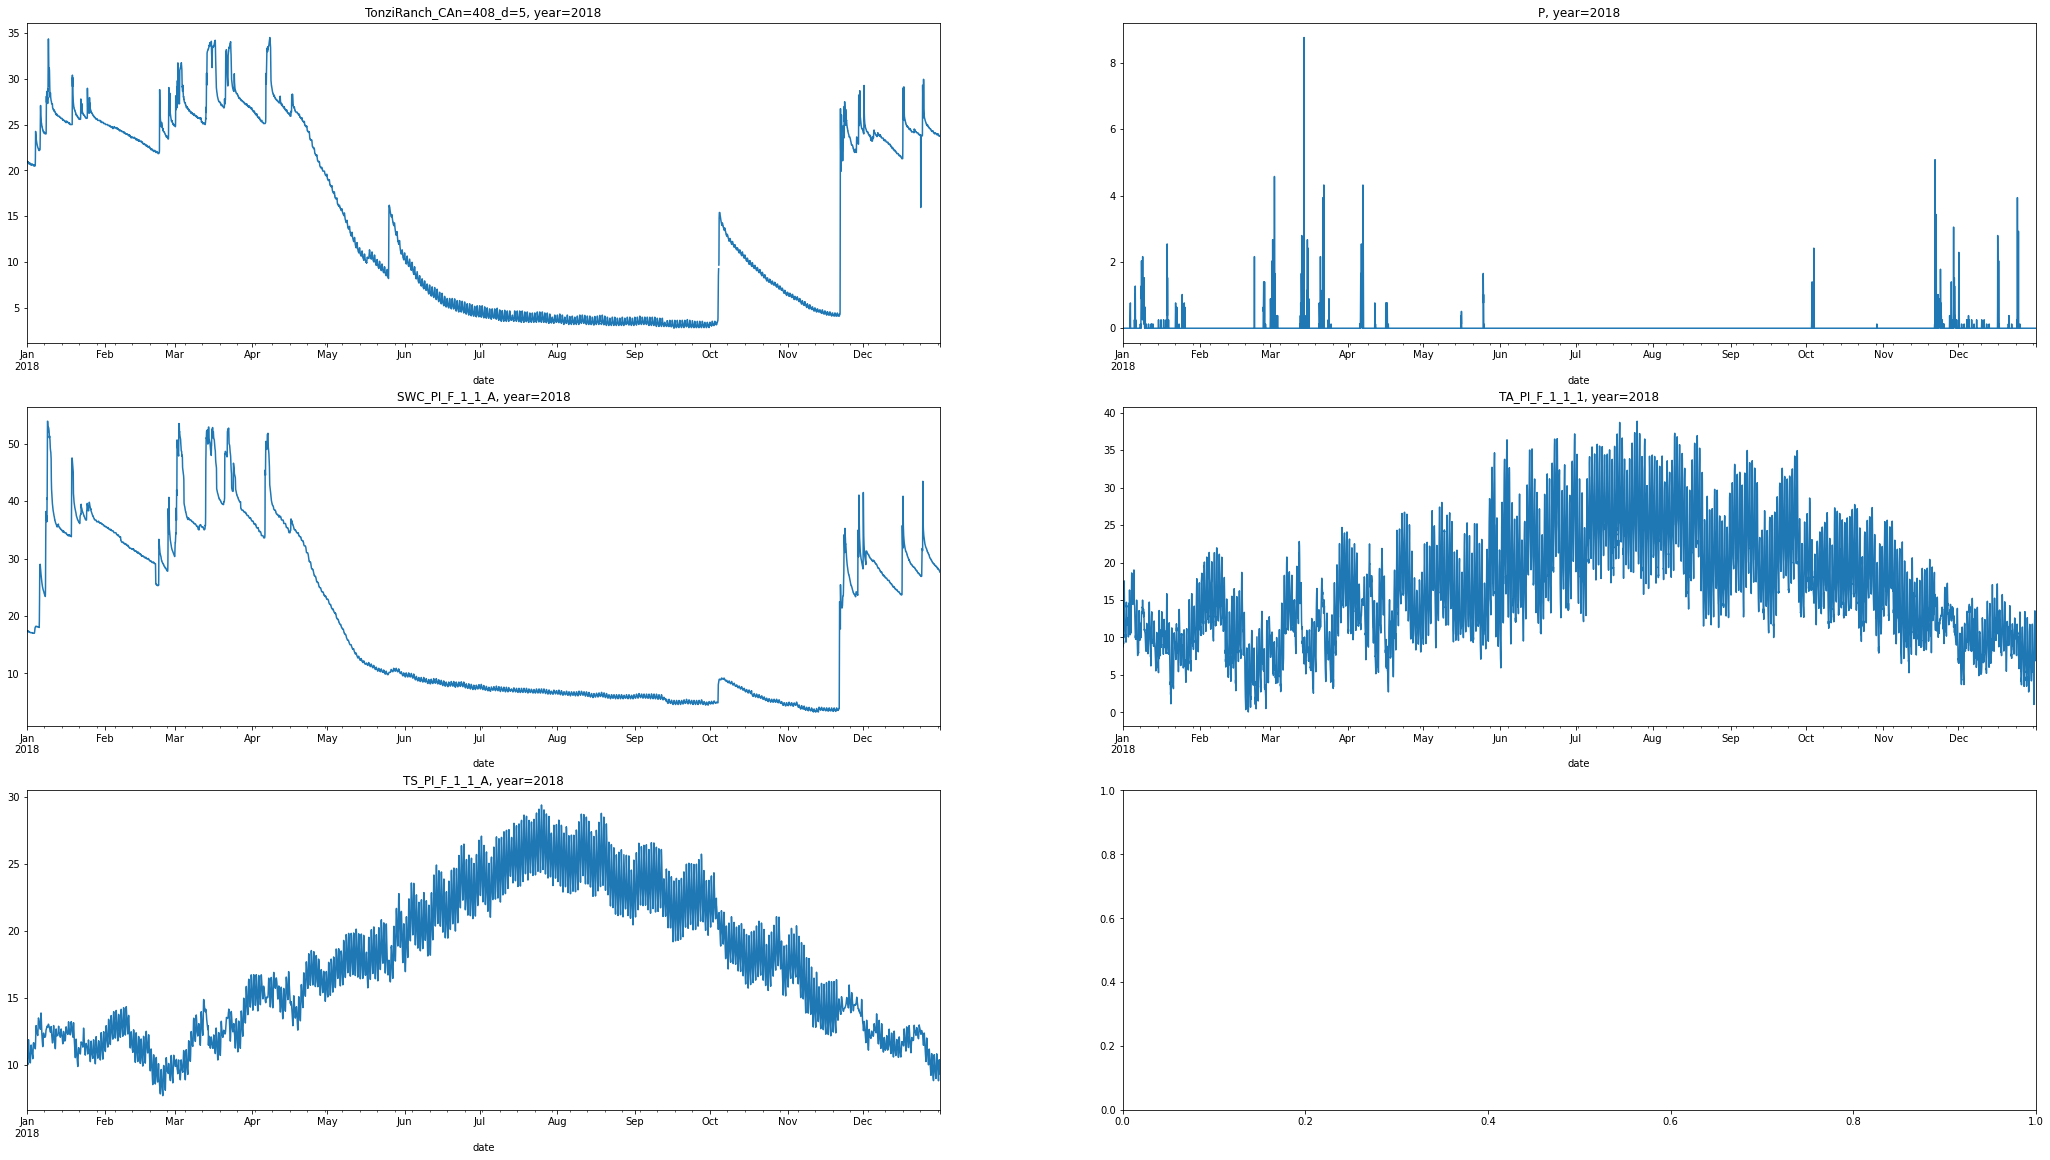

In [18]:
# fig, axes = plt.subplots(nrow, ncol)
row = 3
col = 10
plt.figure(figsize = (100,100))
c=np.array(merged_df_dict[key].columns)
col = round(len(merged_df_dict[key].columns)/3)
c.resize((row,col))
fig,axes = plt.subplots(row,col)
for i in range(0,row,1):
    for j in range(0,col,1):
        if c[i][j] in merged_df_dict[key].columns:
            merged_df_dict[key][c[i][j]].plot(ax = axes[i,j],figsize=(36,20) , title =c[i][j]+", year="+key)
# fig.savefig(os.path.join('/home/sonakshireddy/Documents/yearly_plots_tonzi/' + 'testing' + ".png"))
# plt.close('all')
# ax = merged_df_dict[key].plot(title=key.upper(),
#                                figsize=(40, 20),subplots=True,layout = (4,8))


### Saving plots - yearly data of ameriflux and soilscape sites that are related ( tonzi to be specific) 

In [ ]:
for key in merged_df_dict:
    row = 3
    col = 10
    plt.figure(figsize = (100,100))
    c=np.array(merged_df_dict[key].columns)
    col = round(len(merged_df_dict[key].columns)/3)
    c.resize((row,col))
    fig,axes = plt.subplots(row,col)
    for i in range(0,row,1):
        for j in range(0,col,1):
            if c[i][j] in merged_df_dict[key].columns:
                merged_df_dict[key][c[i][j]].plot(ax = axes[i,j],figsize=(36,20) , title =c[i][j]+", year="+key)
    fig.savefig(os.path.join('/home/sonakshireddy/Documents/yearly_plots_tonzi/' + key + ".png"))
    plt.close('all')

In [ ]:
# col ='SWC_PI_1_1_A'
# sample = filtered[col]
# sample = sample.dropna()
# sample.index = pd.to_datetime(sample.index)
# s1 =sample.resample('H').mean()


# x = pd.DataFrame(s1)
# x.index = pd.to_datetime(x.index)
# x['time'] = x.index
# res_tup = []

# # x.groupby(pd.Grouper(key='time',freq='Y')).apply(lambda x:plot_hist(x,res_tup,col))


In [ ]:
# x=x.dropna()
# x.time = x.index
# x[(x.index>='2002-01-01') & (x.index < '2003-01-01')].groupby(pd.Grouper(key='time',freq='m')).apply(lambda x:print(x.index[0].month,x.shape[0]/24))

In [19]:
def find_longest_seq_count(s1):
    max_val = 0
    longest_gap = 0
    long_seq = 0
    max_long_seq = 0
    num_gaps=0
    no_nulls=True
    for val in s1:
        if isNaN(val):
            if max_val==0:
                num_gaps+=1
            no_nulls=False
            max_val+=1
            if max_long_seq<long_seq:
                max_long_seq = long_seq
            long_seq = 0
        else:
            long_seq+=1
            if longest_gap<max_val:
                longest_gap = max_val
            max_val = 0
    if max_long_seq<long_seq:
        max_long_seq = long_seq
    if longest_gap<max_val:
        longest_gap = max_val
    if no_nulls:
        max_long_seq = s1.shape[0]
    return max_long_seq, longest_gap,num_gaps

In [20]:
filtered = pd.read_csv("/home/sonakshireddy/Documents/soil/soil/pred_exp/merge_all_result_hourly.csv",sep=";")
filtered = filtered.sort_values(by=['date'])
filtered.index = filtered.date
filtered=filtered.replace(0,np.nan)

In [22]:
## plotting the outliers for each node and saving the stats of gaps, filled sequences to a csv file
s1=None
outlier_list =[]
try:
    list_dict = []
    list_cols = list(filtered.columns)
    list_cols.remove('date')
    for col in list_cols:
        d1={}
        sample = filtered[col]
        sample = sample.dropna()
        if not sample.empty and sample.shape[0]>10:
            sample.index = pd.to_datetime(sample.index)
            d1['site'] = col.split("n=")[0]
            node_id = col.split("n=")[1].split("_")[0]
            d1['depth'] = col.split("n=")[1].split("_d=")[1]
            s1 =sample.resample('D').mean()
            s = validate_series(s1)
            iqr_ad = InterQuartileRangeAD(c=1.5)
            anomalies = iqr_ad.fit_detect(s)
#             a=anomalies[~isNaN(anomalies)]
#             a=a[a>0]
#             if not a.empty:
#                 s = s.dropna()
#                 s[s.index.isin(list(a.index))] = np.nan
#                 s = pd.DataFrame(s)
#                 s = s.assign(InterpolateTime=s.interpolate(method='time'))
#                 s[col] = sample
#                 anomalies1 = iqr_ad.fit_detect(s)
#                 if anomalies1[anomalies1.InterpolateTime>0]['InterpolateTime'].shape[0]>0:
            plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
            fig = plt.gcf()
            plt.xlabel('date')
            plt.ylabel('soil moisture')
            plt.title("SITE = " + d1['site']+ ",  NODE_ID = " + node_id + ",  DEPTH = "+d1['depth'])
            fig.savefig('C:/Users/M Sonakshi/Documents/soil_imgs/countVis/'+col+".png")
            plt.close('all')           
            d1['node_id'] = node_id
            d1['total_rows'] = s1.shape[0]
            d1['start'] =  s1.index[0].date()
            d1['end'] =  s1.index[-1].date()
            max_long_seq, longest_gap,num_gaps = find_longest_seq_count(s1)
            d1['nulls'] = s1.isnull().sum()
            d1['filled_percentage'] = 1 - d1['nulls']/float(d1['total_rows'])
            d1['longest_gap'] = longest_gap
            d1['longest_seq'] = max_long_seq
            d1['num_gaps'] = num_gaps
            list_dict.append(d1)
    with open("C:/Users/M Sonakshi/Documents/soil_imgs/countVis/nodewisefiltered.csv",'w',newline="") as f:
        keys = list_dict[0].keys()
        writer = csv.DictWriter(f,['site','node_id','depth','start','end','nulls','total_rows','filled_percentage','longest_gap','longest_seq','num_gaps'])
        writer.writeheader()
        writer.writerows(list_dict)
except Exception as e:
    print(e)
#     print(s1)
                

### Printing Anamolies for different fields

In [ ]:
# for col in filtered.columns:
#     try:
#         s = filtered[col]
#         s.index = pd.DatetimeIndex(filtered.index)
#         s = validate_series(s)
#         iqr_ad = InterQuartileRangeAD(c=1.5)
#         anomalies = iqr_ad.fit_detect(s)
#         plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
#         fig = plt.gcf()
#         fig.savefig('C:/Users/M Sonakshi/Documents/soil_imgs/anamolies/'+col+".png")
#         plt.close('all')
#     except Exception as e:
#         print(e)
#         print(s)

In [ ]:
col = "BLMLand3NTonzi_CA_n=1202_d=42"
s1 = filtered[col]
s1.index = pd.to_datetime(filtered.index)
s1 =s1.dropna()
s = validate_series(s1)
iqr_ad = InterQuartileRangeAD(c=1.5)
anomalies = iqr_ad.fit_detect(s)
ax = plot(s, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");
# fig = plt.gcf()
# plt.xlabel('date')
# plt.ylabel('soil moisture')
# plt.title("SITE = " + "Kendall_AZ"+ ",  NODE_ID = " + "1406"+",  DEPTH = "+"15")
# fig.savefig('output.png')

In [ ]:
a=anomalies[~isNaN(anomalies)]
a=a[a>0]
s[s.index.isin(list(a.index))] = np.nan
s = pd.DataFrame(s)
samp=s
s = s.assign(InterpolateTime=s.interpolate(method='time'))
s[col] = s1
anomalies1 = iqr_ad.fit_detect(s)
ax = plot(s, anomaly=anomalies1, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker");